In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [54]:
# read in cleaned weather, air quality, drilling, and production files
AQ_data = pd.read_csv('FarmingtonCommunityHall_AQ.csv')
weather_data = pd.read_csv('weather_data.csv')
drill_data = pd.read_csv('drill_final.csv')
production_data_monthly = pd.read_csv('production_monthly.csv')
production_data_daily = pd.read_csv('production_daily.csv')

# drop the WDIR_UVEC_(DEG) column
weather_data.drop('WDIR_UVEC_(DEG)', axis=1, inplace=True)

# combine cleaned file into one dataframe
AQ_weather_hourly = weather_data.merge(right=AQ_data,
                                     how='inner')
# Reset DateTimeIndex
AQ_weather_hourly = AQ_weather_hourly.set_index(pd.DatetimeIndex(AQ_weather_hourly['Datetime']))

# Resample AQ and weather to daily
AQ_weather_daily = AQ_weather_hourly.resample('D').mean()

# Combine daily weather, AQ and drilling and production
drill_data.rename(columns={'Date':'Datetime'}, inplace=True)
drill_data = drill_data.set_index(pd.DatetimeIndex(drill_data['Datetime']))
drill_data.drop('Datetime', axis=1, inplace=True)
AQ_weather_drilling_daily = AQ_weather_daily.merge(right=drill_data,
                                                  how='inner',
                                                  left_index=True,
                                                  right_index=True)

production_data_daily.rename(columns={'Date':'Datetime'}, inplace=True)
production_data_daily = production_data_daily.set_index(pd.DatetimeIndex(production_data_daily['Datetime']))
production_data_daily.drop('Datetime', axis=1, inplace=True)

AQ_weather_drilling_prod_daily = AQ_weather_drilling_daily.merge(right=production_data_daily,
                                                                 how='inner',
                                                                 left_index=True,
                                                                 right_index=True)
# View df
AQ_weather_drilling_prod_daily.head()


,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3,Depth_per_day,gas_prod_vol_m3
Datetime,,,,,,,,,,,,
2019-01-01,2.879167,261.875000,7.595833,68.220833,0.820833,0.333333,0.268750,0.543750,0.183333,37.122917,252.000000,168187.648387
2019-01-02,4.066667,256.179167,8.525000,64.683333,0.739583,0.283333,0.229167,0.510417,0.104167,37.287500,252.000000,168187.648387
2019-01-03,-6.262500,281.950000,2.079167,72.279167,6.056250,0.297917,0.677083,5.362500,0.110417,28.483333,588.502415,168187.648387
2019-01-04,-7.912500,187.333333,0.779167,88.525000,6.258333,0.687500,0.377083,5.879167,0.172917,24.160417,807.002415,168187.648387
2019-01-05,-9.120833,121.070833,1.870833,88.825000,5.381250,1.010417,0.737500,4.652083,0.139583,26.127083,807.002415,168187.648387


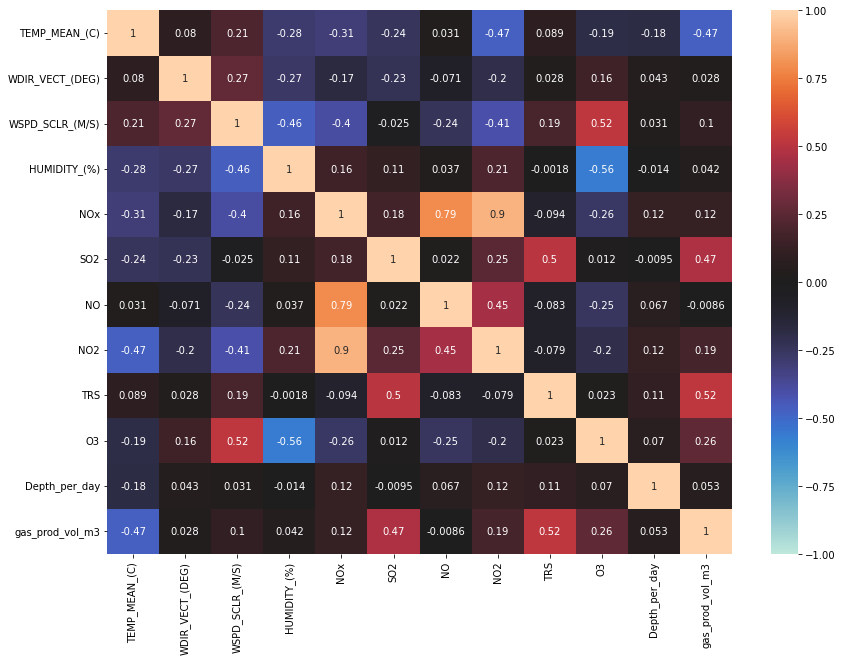

In [16]:
# plot correlation heat map for all parameters

plt.figure(figsize=(14,10))
sns.heatmap(AQ_weather_drilling_prod_daily.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.show()

In [55]:
# monthly dfs
# have to resample seperately - drilling and production needs sum and AQ and weather need mean

# drilling
drill_data_monthly = drill_data.resample('m').sum()

# production
production_data_monthly.rename(columns={'Date':'Datetime'}, inplace=True)
production_data_monthly = production_data_monthly.set_index(pd.DatetimeIndex(production_data_monthly['Datetime']))
production_data_monthly.drop('Datetime', axis=1, inplace=True)

# Add common column with just year and month to merge on
drill_data_monthly['month'] = drill_data_monthly.index.get_level_values('Datetime').to_period('M')
production_data_monthly['month'] = production_data_monthly.index.get_level_values('Datetime').to_period('M')

# merge datasets keeping the index of drilling
drilling_prod_monthly = drill_data_monthly.merge(right=production_data_monthly,
                                                  how='inner',
                                                  on='month')
drilling_prod_monthly.set_index(drill_data_monthly.index, inplace=True)
drilling_prod_monthly.drop('month', axis=1, inplace=True)

# resample weather and AQ monthly
AQ_weather_monthly = AQ_weather_hourly.resample('m').mean()

# merge with AQ and weather file
AQ_weather_drilling_prod_monthly = AQ_weather_monthly.merge(right=drilling_prod_monthly,
                                                  how='inner',
                                                  left_index=True,
                                                  right_index=True)
AQ_weather_drilling_prod_monthly.head()

,TEMP_MEAN_(C),WDIR_VECT_(DEG),WSPD_SCLR_(M/S),HUMIDITY_(%),NOx,SO2,NO,NO2,TRS,O3,Depth_per_day,gas_prod_vol_m3
Datetime,,,,,,,,,,,,
2019-01-31,-8.364919,225.636962,3.024328,75.877151,5.786626,0.438038,1.044422,4.743817,0.147849,27.624462,98952.575762,5213817.1
2019-02-28,-19.748512,227.183185,1.693452,69.316815,7.262426,0.561086,1.240030,6.024702,0.212054,29.353199,180173.980937,4704358.5
2019-03-31,-3.087097,248.195565,2.157930,62.530780,5.068884,0.409946,0.781788,4.288777,0.174530,34.263306,216898.369108,5223571.0
2019-04-30,3.420625,224.523403,3.285486,57.080972,2.056181,0.290000,0.337431,1.718194,0.142292,34.923264,219187.235484,4807638.7
2019-05-31,10.465188,191.305376,1.963172,57.111156,3.302083,0.211358,0.691868,2.613777,0.160820,30.106384,187231.816727,4561579.5


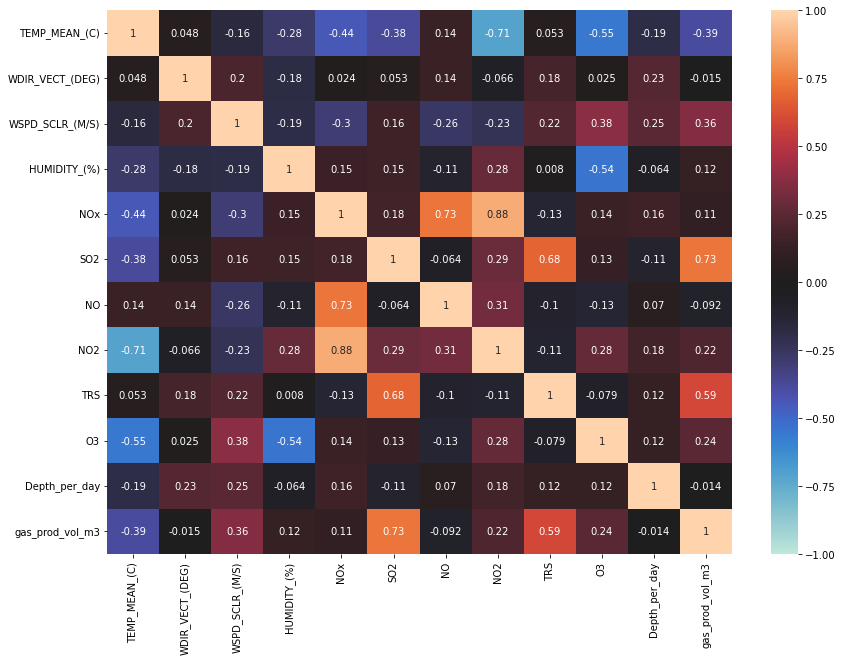

In [56]:
# plot correlation heat map for all parameters

plt.figure(figsize=(14,10))
sns.heatmap(AQ_weather_drilling_prod_monthly.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.show()

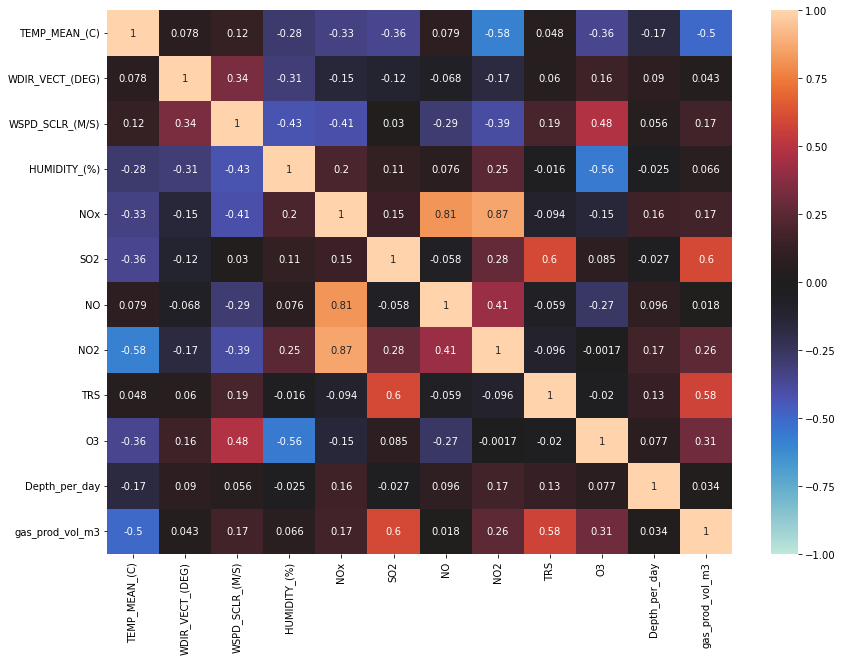

In [159]:
week_mean = AQ_weather_drilling_prod_daily.resample('w').mean()
plt.figure(figsize=(14,10))
sns.heatmap(week_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.show()

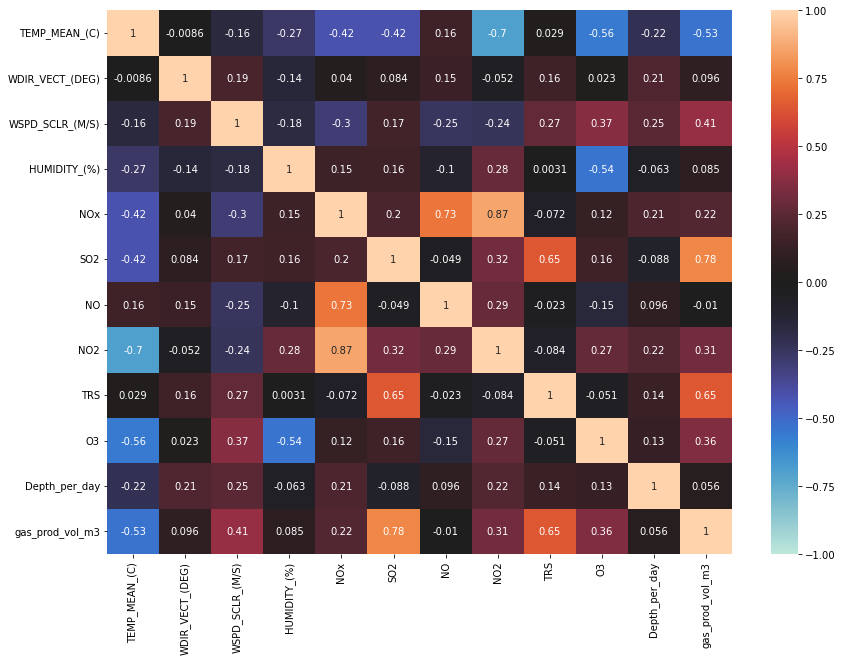

In [160]:
month_mean = AQ_weather_drilling_prod_daily.resample('m').mean()
plt.figure(figsize=(14,10))
sns.heatmap(month_mean.corr(), vmin=-1, vmax=1, annot=True, cmap='icefire')
plt.show()

MODEL DEVELOPMENT:
From the above heat map we can see that TRS is correlated with the monthly gas production. SO2 is correlated with the temperature and the monthly gas production.

In [135]:
# model for SO2
X =  AQ_weather_drilling_prod_monthly.filter(['TEMP_MEAN_(C)', 'gas_prod_vol_m3'], axis=1)
y = AQ_weather_drilling_prod_monthly.filter(['SO2'], axis=1)

# Split the data into a training and a testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print('Train {}%'.format(X_train.shape[0] / AQ_weather_drilling_prod_monthly.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / AQ_weather_drilling_prod_monthly.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [136]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm

# create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# fit model
linear_model.fit(X_train, y_train)

# predict training data y
y_fitted = linear_model.predict(X_train)

In [137]:
from sklearn.metrics import r2_score

print(r2_score(y_train, y_fitted))

0.5774002296413805


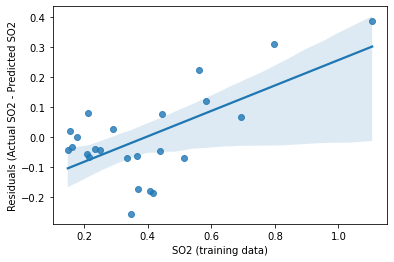

In [138]:
# plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['SO2'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')

plt.show()

In [139]:
# test data
y_fitted = linear_model.predict(X_test)

print(r2_score(y_test, y_fitted))

0.42837412854969437


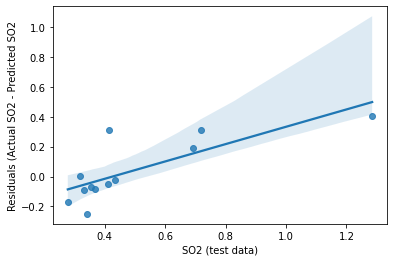

In [140]:
# plot the residuals
residuals = y_test - y_fitted
ax = sns.regplot(x=y_test, y=residuals['SO2'])
ax.set_xlabel('SO2 (test data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')

plt.show()

In [141]:
# try a polynomial regression instead of linear
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)


In [144]:
poly_features = poly.fit_transform(X_train)

poly_reg_model = LinearRegression()

poly_reg_model.fit(poly_features,y_train)
y_fitted = poly_reg_model.predict(poly_features)


In [145]:
print(r2_score(y_train, y_fitted))

0.8162613060613385


In [148]:
poly_features = poly.fit_transform(X_test)
y_fitted = poly_reg_model.predict(poly_features)

print(r2_score(y_test, y_fitted))

0.808072291311644


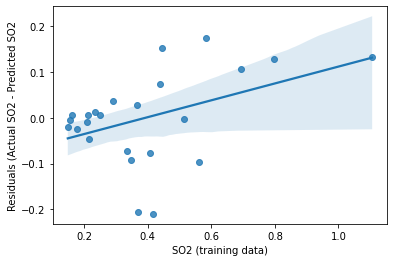

In [146]:
# plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['SO2'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual SO2 - Predicted SO2')

plt.show()

In [151]:
# model for TRS
X =  AQ_weather_drilling_prod_monthly.filter(['TEMP_MEAN_(C)', 'gas_prod_vol_m3'], axis=1)
y = AQ_weather_drilling_prod_monthly.filter(['TRS'], axis=1)

# Split the data into a training and a testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print('Train {}%'.format(X_train.shape[0] / AQ_weather_drilling_prod_monthly.shape[0] * 100))
print('Test {}%'.format(X_test.shape[0] / AQ_weather_drilling_prod_monthly.shape[0] * 100))

Train 66.66666666666666%
Test 33.33333333333333%


In [129]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm

# create a LinearRegression object and name it linear_model
linear_model = lm.LinearRegression(fit_intercept=True)

# fit model
linear_model.fit(X_train, y_train)

# predict training data y
y_fitted = linear_model.predict(X_train)

In [130]:
from sklearn.metrics import r2_score

print(r2_score(y_train, y_fitted))

0.47892345697284355


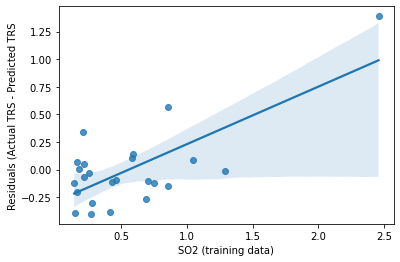

In [131]:
# plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['TRS'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')

plt.show()

In [132]:
# test data
y_fitted = linear_model.predict(X_test)

print(r2_score(y_test, y_fitted))

0.3095189937979522


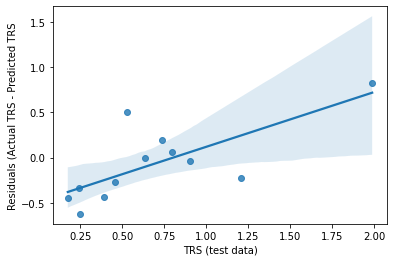

In [133]:
# plot the residuals
residuals = y_test - y_fitted
ax = sns.regplot(x=y_test, y=residuals['TRS'])
ax.set_xlabel('TRS (test data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')

plt.show()

In [155]:
poly_features = poly.fit_transform(X_train)

poly_reg_model = LinearRegression()

poly_reg_model.fit(poly_features,y_train)
y_fitted = poly_reg_model.predict(poly_features)

print(r2_score(y_train, y_fitted))

0.6771169930589103


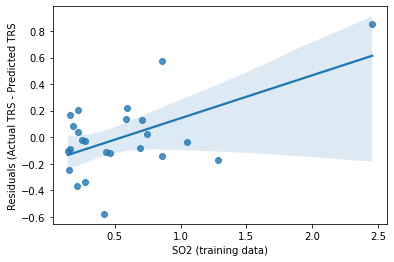

In [156]:
# plot the residuals
residuals = y_train - y_fitted
ax = sns.regplot(x=y_train, y=residuals['TRS'])
ax.set_xlabel('SO2 (training data)')
ax.set_ylabel('Residuals (Actual TRS - Predicted TRS')

plt.show()

In [153]:
poly_features = poly.fit_transform(X_test)
y_fitted = poly_reg_model.predict(poly_features)

print(r2_score(y_test, y_fitted))

0.3952831323221919
